# import

In [78]:
import pandas as pd
import numpy as np
import os, sys, glob, re
from pathlib import Path
from scipy.interpolate import interp2d
from emgineer import EmgDecomposition, plot_spikes
import matplotlib.pyplot as plt

import itertools
from sklearn.metrics.pairwise import cosine_similarity
from statistics import median,variance,stdev
from scipy import stats
import math

sys.path.append('../load_intan_rhd_format')

from load_filt_test import read_data, guolv

def filt_all_rhd(path):
    rhd = read_data(path)
    array_emg = rhd['amplifier_data']
    array_emg = array_emg[:, 2000:]
    array_emg_filt = guolv(array_emg).T
    return array_emg_filt

def get_newest_file(path_root):
    list_filename = [os.path.basename(p) for p in glob.glob(path_root + '/*', recursive=True) 
                    if re.search('(\w|\W)*[0-9]{6}_[0-9]{6}', os.path.basename(p))]
    filename = [i for _,i in sorted(zip([x[-13:] for x in list_filename],list_filename), reverse=True)][0]
    return filename

def plot_sensor_grid(M, n_lim=None, figsize=(16.0, 10.0), cmap='viridis', interporate_rate=1):
    if n_lim is None:
        n_lim = M.shape[0]
    plt.rcParams['figure.figsize'] = figsize
    fig = plt.figure()
    fig, axes = plt.subplots(nrows=-(-n_lim//5), ncols=5, sharex=False)
    for i in range(n_lim):
        _electrodes = M[i, :64].reshape((8, 8))
        if interporate_rate != 1:
            _electrodes = interporate_grid(_electrodes, rate=interporate_rate)
        axes[i//5, i%5].pcolor(_electrodes, cmap=cmap)
        axes[i//5, i%5].tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
            bottom=False,
            left=False,
            right=False,
            top=False)
        axes[i//5, i%5].set_title('MU ' + str(i))

def interporate_grid(Z, rate=2):
    x = np.linspace(0, 7, 8)
    y = np.linspace(0, 7, 8)
    
    x2 = np.linspace(0, 7, int(8 * rate))
    y2 = np.linspace(0, 7, int(8 * rate))
    # X2, Y2 = np.meshgrid(x2, y2)

    f = interp2d(x, y, Z, kind='cubic')
    Z2 = f(x2, y2)
    return Z2

def confidence_interval(x, alpha=0.95):
    bottom, up = stats.norm.interval(alpha=alpha, loc=np.mean(x), scale=stdev(x))
    return bottom, up

def smirnov_grubbs(data, alpha):
	x, o = list(data), []
	while True:
		n = len(x)
		t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)
		tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)
		i_min, i_max = np.argmin(x), np.argmax(x)
		myu, std = np.mean(x), np.std(x, ddof=1)
		i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
		tau_far = np.abs((x[i_far] - myu) / std)
		if tau_far < tau: break
		o.append(x.pop(i_far))
	return (np.array(x), np.array(o))

# Decomp

In [70]:
path_root = 'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/20221220_zhang'
filename = get_newest_file(path_root)
filename = 'five_221220_133845'

path = f'{path_root}/{filename}/{filename}.rhd'
emg_filt = filt_all_rhd(path)
emg_flex = emg_filt[:, :64]


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 128 amplifier channels.
Found 6 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 34.496 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.7 seconds


start decomp
end decomp


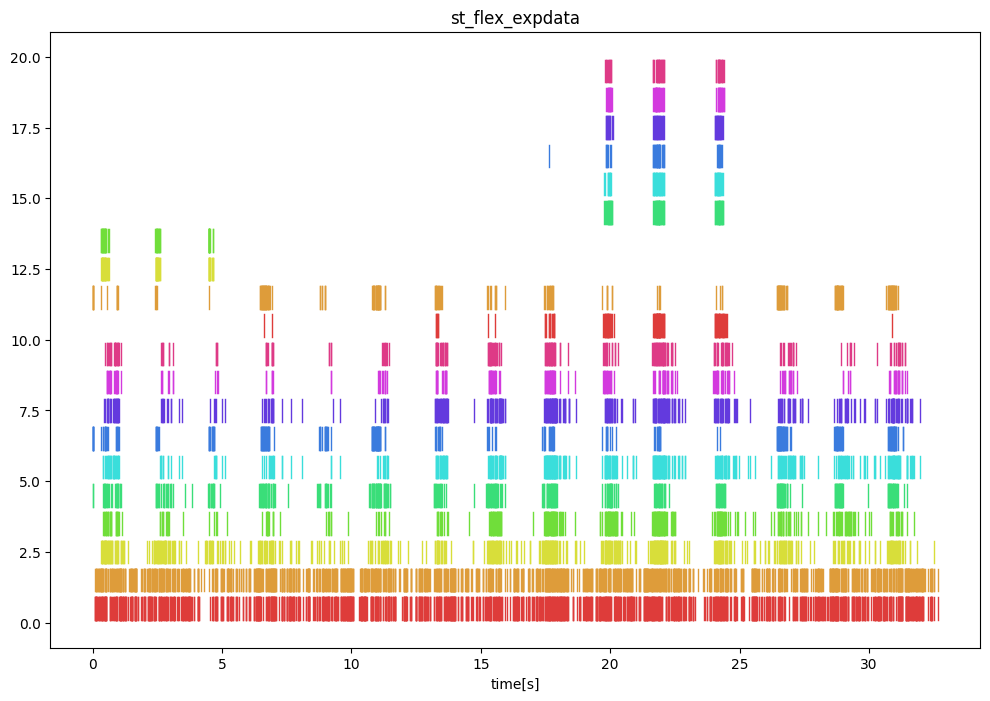

In [71]:
# param
n_motor_unit = 20

# decomp
print('start decomp')
est_flex = EmgDecomposition(
    n_motor_unit=n_motor_unit,
    n_delayed=8,
    random_state=0,
    cashe= os.path.basename(path_root)[9:] +'_' + filename + '_mu' + str(n_motor_unit),
    flag_sil=False,
    flag_pca=False)
est_flex.fit(emg_flex)
st_flex, mu_flex = est_flex.transform(emg_flex)

print('end decomp')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plot_spikes(st_flex[:, :20][:, ::-1], title='st_flex_expdata')

# 解析

## n_motor_unitの決定

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

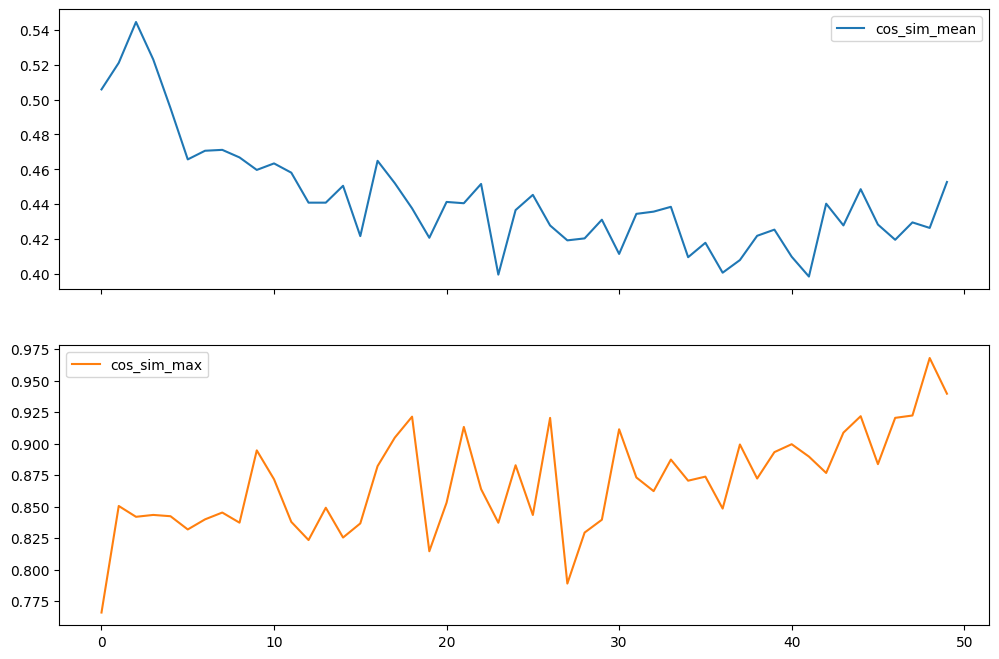

In [89]:
list_cos_sim_mean = []
list_cos_sim_max = []

for _n_motor_unit in range(5, 55):
    print(_n_motor_unit)
    # decomp
    est_flex = EmgDecomposition(
        n_motor_unit=_n_motor_unit,
        n_delayed=8,
        random_state=0,
        cashe= os.path.basename(path_root)[9:] +'_' + filename + '_mu' + str(_n_motor_unit),
        flag_sil=False,
        flag_pca=False)
    est_flex.fit(emg_flex)
    #st_flex, mu_flex = est_flex.transform(emg_flex)
    
    # cosine similarity
    mat_cos_sim = cosine_similarity(np.square(est_flex._FastICA.mixing_.T))
    array_cos_sim = np.triu(mat_cos_sim, k=1).flatten()
    array_cos_sim = np.delete(array_cos_sim, np.where(array_cos_sim == 0)[0].tolist())

    #_comb = math.comb(est_flex._FastICA.mixing_.T.shape[0], 2)
    list_cos_sim_mean.append(array_cos_sim.mean())
    list_cos_sim_max.append(array_cos_sim.max())   


df_cos_sim = pd.DataFrame(
    {
        'cos_sim_mean': list_cos_sim_mean,
        'cos_sim_max': list_cos_sim_max
    })
#df_cos_sim.to_csv(os.path.basename(path_root)[9:] +'_' + filename + '.csv', index=False)
df_cos_sim.plot(subplots=True)

### ランダムな64次元ベクトルのコサイン類似度における次元の呪い(収束値は十分に小さい値である)

0.852593144044578
0.6496193605547329


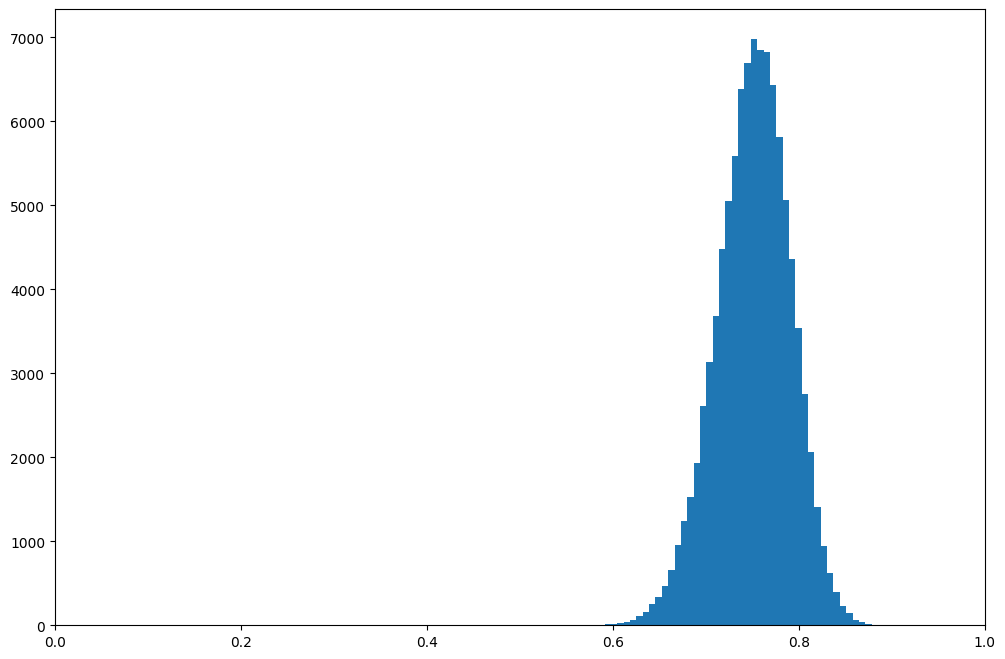

In [88]:
array_cos_sim_random = []
for i in range(100000):
    array_cos_sim_random.append(cosine_similarity(np.random.rand(2, 64))[0][1])
_bottom, _up = confidence_interval(array_cos_sim_random, alpha=0.99)
print(_up)
print(_bottom)
plt.xlim(0, 1) 
_ = plt.hist(array_cos_sim_random, bins=50)

In [ ]:
#list_cos_sim = [cosine_similarity(v[0].reshape((1, -1)), v[1].reshape((1, -1)))[0][0] 
#                #for v in itertools.combinations(np.square(mu_flex.T), 2)]
#                for v in itertools.combinations(np.square(est_flex._FastICA.mixing_.T), 2)]

# 混合行列の解析

<Figure size 1600x1000 with 0 Axes>

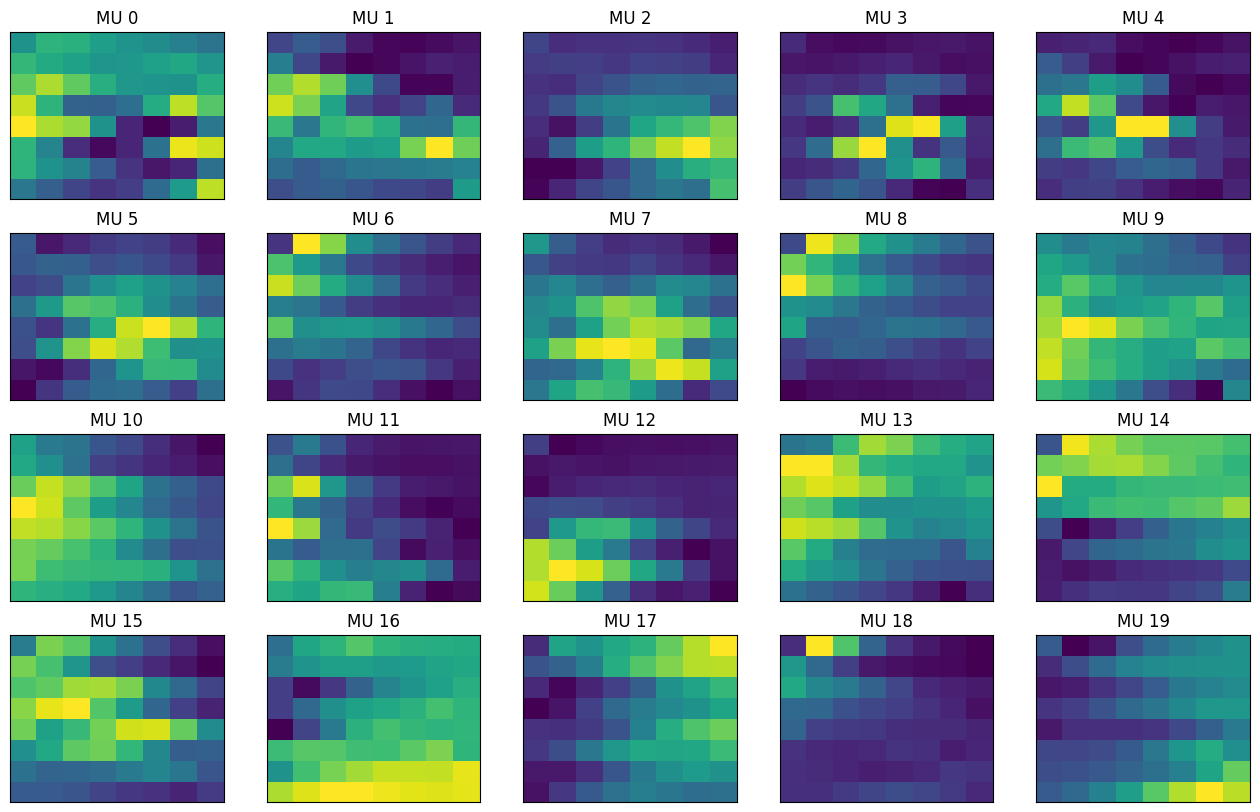

In [58]:
# ここで、C = np.dot(ummixing_matrix, whitening_matrix)
C = est_flex._FastICA.mixing_.T

# extendした信号を足し合わせる, spike trainsを算出するとき負の値は二乗されて正になるので、square(absでもできるが強調のためsquare)
mix_all = np.square(C).reshape((C.shape[0], -1, 64)).sum(axis=1)

def rms(x, axis=None):
    return np.sqrt(np.mean(x**2, axis=axis))
mix_all = rms(C.reshape((C.shape[0], -1, 64)), axis=1)

plot_sensor_grid(mix_all, n_lim=20, interporate_rate=1)